In [48]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing  
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.ticker import MultipleLocator 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Cleaning

# train

In [51]:
path = os.getcwd().split('TianChi_IJCAI-17_footfall_prediction_code')[0]

#shop_info = pd.read_table(path+'dataset/shop_info.txt',names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'],header=None,delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info = pd.read_table(path+'dataset/shop info with count.csv',delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info.index = shop_info['shop_id'].tolist()

In [3]:
shop_info_num = shop_info.iloc[:,:10].copy()

In [4]:
weekA = shop_info.loc[:,'2016-09-20':'2016-09-26'].copy()
weekB = shop_info.loc[:,'2016-10-11':'2016-10-17'].copy()
weekC = shop_info.loc[:,'2016-10-18':'2016-10-24'].copy()
weekD = shop_info.loc[:,'2016-10-25':'2016-10-31'].copy()

In [5]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
train_x = weekA.join(weekB)                                    #train = weekA+ weekB + weekC
train_x = train_x.join(weekC)

In [6]:
train_x

,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-10-11,2016-10-12,2016-10-13,...,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24
1,223,206,220,241,272,240,225,254,239,228,...,264,264,207,244,177,207,230,202,243,216
2,77,82,71,71,96,121,67,0,0,0,...,0,0,0,0,0,0,61,155,143,78
3,62,59,55,79,112,83,88,68,63,56,...,119,97,75,59,71,88,103,127,125,47
4,74,101,102,98,203,199,91,86,113,71,...,165,200,89,90,112,59,80,211,221,81
5,277,272,309,182,179,4,305,223,218,230,...,185,211,274,201,210,221,187,161,240,454
6,77,68,74,73,67,89,83,83,91,90,...,112,137,83,104,104,90,107,88,76,104
7,105,116,105,141,168,180,109,136,93,128,...,183,208,135,101,94,113,132,152,200,124
8,62,65,57,71,69,73,55,81,63,65,...,103,101,66,49,55,73,46,68,89,68
9,238,214,229,242,288,324,212,225,202,192,...,251,282,254,180,213,226,208,220,310,246
10,73,104,69,76,73,89,80,108,111,73,...,76,103,96,90,139,93,84,92,115,60


In [7]:

def every_shop_open_ratio(start_day,end_day):
    Row = len(shop_info.index.tolist())
    row = 0
    Open_ratios = []
    while(row<Row):
        single_row = shop_info.iloc[row]
        single_row = single_row[start_day:end_day]
        open_ratio_ = (single_row>0).sum()/float((pd.to_datetime(end_day).date()-pd.to_datetime(start_day).date()).days+1)
        Open_ratios.append(round(open_ratio_,4))
        row = row+1
    Open_ratios = np.array(Open_ratios)
 
  
    mask = Open_ratios>=0
    df = DataFrame({'shop_id':(shop_info.shop_id)[mask].values,'open_ratio':Open_ratios[mask]},index=np.arange(1,2001))
    return  df   #返回大于threshold的shop_id,以及他们对应的开张比例


In [8]:
train_sum = train_x.sum(axis=1)
train_mean = train_x.mean(axis=1)
train_open_ratio_A = every_shop_open_ratio(start_day='2016-09-20',end_day='2016-09-26')
train_open_ratio_BC = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-24')
train_open_ratio = (train_open_ratio_A.open_ratio + train_open_ratio_BC.open_ratio*2)/3
train_weekend = ['2016-09-24','2016-09-25','2016-10-15','2016-10-16','2016-10-22','2016-10-23']
train_ratio_wk = (train_x[train_weekend]).sum(axis=1)/(train_sum.replace(0,1))
train_std = train_x.std(axis=1)
train_max = train_x.max(axis=1)
train_min = train_x.min(axis=1)
train_median = train_x.median(axis=1)
train_mad = train_x.mad(axis=1)
train_var = train_x.var(axis=1) 

In [9]:
'''将多维数组转换为DataFrame'''
def transfrom_Arr_DF(arr,col_name = 'col_'):
    if(len(arr.shape)==1):
        df = DataFrame(arr,columns=['col_0'])
    else:
        df = DataFrame(arr,columns=[col_name+str(i) for i in range(arr.shape[1])],index=np.arange(1,len(arr)+1))
    return df

'''将一维数组转换为OHE码'''
def make_OHE(names):
    data = []
    for name in names:
        data.append([name])          
    enc = preprocessing.OneHotEncoder()
    enc.fit(data)
    OHE_data = enc.transform(data).toarray()  
    return OHE_data


In [10]:
shop_info_num['score'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['comment_cnt'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['cate_3_name'].replace(np.NaN,u'NaN',inplace=True)

In [11]:
city_name_usual=[u'上海',u'杭州',u'北京',u'广州',u'南京',u'武汉',u'深圳']
shop_info_num.loc[~shop_info_num['city_name'].isin(city_name_usual),'city_name'] = u'其他城市'
cate_1_name_usual=[u'美食',u'超市便利店']
shop_info_num.loc[~shop_info_num['cate_1_name'].isin(cate_1_name_usual),'cate_1_name'] = u'其他'
cate_2_name_usual=[u'快餐',u'超市',u'便利店',u'休闲茶饮',u'小吃',u'休闲食品',u'烘焙糕点',u'中餐',u'其他美食',u'火锅']
shop_info_num.loc[~shop_info_num['cate_2_name'].isin(cate_2_name_usual),'cate_2_name'] = u'其他'
cate_3_name_usual=[u'西式快餐',u'中式快餐',u'生鲜水果',u'奶茶',u'其它小吃',u'面包',u'饮品/甜点',u'面点',u'蛋糕']
shop_info_num.loc[~shop_info_num['cate_3_name'].isin(cate_3_name_usual),'cate_3_name'] = u'其他'


,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
1,1,其他城市,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
2,2,其他城市,64,19,-1.0,-1.0,1,超市便利店,超市,其他
3,3,其他城市,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
4,4,其他城市,380,18,-1.0,-1.0,1,超市便利店,超市,其他
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果
6,6,其他城市,1139,13,3.0,1.0,0,美食,烘焙糕点,面包
7,7,其他城市,145,13,3.0,9.0,2,美食,快餐,西式快餐
8,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果
9,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,其他
10,10,其他城市,98,10,-1.0,-1.0,0,超市便利店,超市,其他


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,cate_3_name__中式快餐,cate_3_name__其他,cate_3_name__其它小吃,cate_3_name__奶茶,cate_3_name__生鲜水果,cate_3_name__蛋糕,cate_3_name__西式快餐,cate_3_name__面包,cate_3_name__面点,cate_3_name__饮品/甜点
1,223.0,206.0,220.0,241.0,272.0,240.0,225.0,254.0,239.0,228.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,77.0,82.0,71.0,71.0,96.0,121.0,67.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62.0,59.0,55.0,79.0,112.0,83.0,88.0,68.0,63.0,56.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74.0,101.0,102.0,98.0,203.0,199.0,91.0,86.0,113.0,71.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,277.0,272.0,309.0,182.0,179.0,4.0,305.0,223.0,218.0,230.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,77.0,68.0,74.0,73.0,67.0,89.0,83.0,83.0,91.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,105.0,116.0,105.0,141.0,168.0,180.0,109.0,136.0,93.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,62.0,65.0,57.0,71.0,69.0,73.0,55.0,81.0,63.0,65.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,238.0,214.0,229.0,242.0,288.0,324.0,212.0,225.0,202.0,192.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,73.0,104.0,69.0,76.0,73.0,89.0,80.0,108.0,111.0,73.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[  2.23000000e+02,   2.06000000e+02,   2.20000000e+02, ...,
          4.90860000e+04,   4.36320000e+04,   5.24880000e+04],
       [  7.70000000e+01,   8.20000000e+01,   7.10000000e+01, ...,
          2.21650000e+04,   1.20900000e+04,   1.11540000e+04],
       [  6.20000000e+01,   5.90000000e+01,   5.50000000e+01, ...,
          1.58750000e+04,   5.96900000e+03,   5.87500000e+03],
       ..., 
       [  3.97000000e+02,   4.12000000e+02,   4.49000000e+02, ...,
          1.03320000e+05,   1.77345000e+05,   1.84664000e+05],
       [  2.70000000e+02,   2.97000000e+02,   2.59000000e+02, ...,
          1.94910000e+05,   1.33500000e+05,   1.31400000e+05],
       [  1.54000000e+02,   1.47000000e+02,   1.68000000e+02, ...,
          3.89400000e+03,   1.06920000e+04,   9.55800000e+03]])

In [14]:
train_x = transfrom_Arr_DF(poly.fit_transform(train_x))

In [15]:

train_x['sumABCD'] = train_sum
train_x['open_ratio'] = train_open_ratio
train_x['ratio_wk'] = train_ratio_wk
train_x['meanABCD'] = train_mean
train_x['std'] = train_std
train_x['max'] = train_max
train_x['min'] = train_min
train_x['median'] = train_median
train_x['mad'] = train_mad
train_x['var'] = train_var

In [16]:
train_x = train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [163]:
train_x = train_x.join(shop_info_num['location_id'])
train_x = train_x.join(shop_info_num['comment_cnt'])

In [212]:
shop_info_num

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
1,1,其他城市,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
2,2,其他城市,64,19,-1.0,-1.0,1,超市便利店,超市,其他
3,3,其他城市,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
4,4,其他城市,380,18,-1.0,-1.0,1,超市便利店,超市,其他
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果
6,6,其他城市,1139,13,3.0,1.0,0,美食,烘焙糕点,面包
7,7,其他城市,145,13,3.0,9.0,2,美食,快餐,西式快餐
8,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果
9,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,其他
10,10,其他城市,98,10,-1.0,-1.0,0,超市便利店,超市,其他


In [255]:
#加入userview
user_view = pd.read_csv(path+'dataset/shop view separately.csv',index_col=0)

In [250]:
user_view

,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name,view_2015-07-01,...,view_2016-10-22,view_2016-10-23,view_2016-10-24,view_2016-10-25,view_2016-10-26,view_2016-10-27,view_2016-10-28,view_2016-10-29,view_2016-10-30,view_2016-10-31
1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点,0,...,27,25,19,21,23,24,21,32,40,14
2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN,0,...,28,25,9,12,10,16,11,29,41,28
3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶,0,...,13,2,4,6,3,4,2,7,8,3
4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN,0,...,40,29,15,13,14,14,12,31,21,20
5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果,0,...,6,5,17,13,13,8,3,5,5,5
6,大连,1139,13,3.0,1.0,0,美食,烘焙糕点,面包,0,...,9,10,7,4,5,7,4,6,13,6
7,绍兴,145,13,3.0,9.0,2,美食,快餐,西式快餐,0,...,15,20,10,10,13,21,34,21,33,10
8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果,0,...,2,2,1,5,2,3,6,1,3,3
9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,NaN,0,...,11,4,2,2,2,2,6,3,11,3
10,孝感,98,10,NaN,NaN,0,超市便利店,超市,NaN,0,...,3,1,1,1,1,1,3,2,0,2


In [ ]:
#加入stable_day_

In [235]:
stable_wave_model = pd.read_csv('stable_wave_model.csv',index_col=0)

In [256]:
train_x = train_x.join(stable_wave_model)

In [257]:
train_x

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,wave_model2_2,wave_model2_3,wave_model2_4,wave_model2_5,wave_model2_6,wave_model2_7,ids_stable_period_1,ids_stable_period_2,ids_stable_period_3,ids_no_stable_period
1,223.0,206.0,220.0,241.0,272.0,240.0,225.0,254.0,239.0,228.0,...,233.500000,245.916667,257.750000,250.833333,234.416667,233.833333,1,0,0,0
2,77.0,82.0,71.0,71.0,96.0,121.0,67.0,0.0,0.0,0.0,...,96.250000,83.375000,90.125000,117.500000,123.000000,91.750000,1,0,0,0
3,62.0,59.0,55.0,79.0,112.0,83.0,88.0,68.0,63.0,56.0,...,71.142857,66.285714,73.428571,81.142857,84.571429,69.000000,0,1,0,0
4,74.0,101.0,102.0,98.0,203.0,199.0,91.0,86.0,113.0,71.0,...,115.428571,102.857143,114.857143,201.714286,220.142857,110.142857,0,1,0,0
5,277.0,272.0,309.0,182.0,179.0,4.0,305.0,223.0,218.0,230.0,...,269.000000,260.285714,217.142857,215.428571,197.142857,309.000000,0,0,1,0
6,77.0,68.0,74.0,73.0,67.0,89.0,83.0,83.0,91.0,90.0,...,46.600000,49.000000,62.400000,57.800000,58.600000,59.000000,0,1,0,0
7,105.0,116.0,105.0,141.0,168.0,180.0,109.0,136.0,93.0,128.0,...,152.200000,170.200000,184.800000,166.000000,212.000000,162.000000,1,0,0,0
8,62.0,65.0,57.0,71.0,69.0,73.0,55.0,81.0,63.0,65.0,...,106.500000,88.000000,95.250000,92.750000,86.000000,75.250000,0,1,0,0
9,238.0,214.0,229.0,242.0,288.0,324.0,212.0,225.0,202.0,192.0,...,205.520000,197.320000,203.760000,230.080000,238.040000,200.160000,1,0,0,0
10,73.0,104.0,69.0,76.0,73.0,89.0,80.0,108.0,111.0,73.0,...,66.000000,50.600000,52.600000,57.400000,72.400000,61.400000,0,0,1,0


In [ ]:
#加入3周余弦相似度

In [ ]:
#加入天气

In [162]:
shop_info_num

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
1,1,其他城市,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
2,2,其他城市,64,19,-1.0,-1.0,1,超市便利店,超市,其他
3,3,其他城市,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
4,4,其他城市,380,18,-1.0,-1.0,1,超市便利店,超市,其他
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果
6,6,其他城市,1139,13,3.0,1.0,0,美食,烘焙糕点,面包
7,7,其他城市,145,13,3.0,9.0,2,美食,快餐,西式快餐
8,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果
9,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,其他
10,10,其他城市,98,10,-1.0,-1.0,0,超市便利店,超市,其他


In [17]:
train_y = weekD

### 检查 train_x train_y 是否符合要求 不包含NaN

In [209]:
 def fresh_ids():
    ids = range(1,2001)
    np.random.shuffle(ids)
    #print ids
    train_set_ids = ids[:1600]
    val_set_ids = ids[1600:]
    return train_set_ids,val_set_ids

In [ ]:
feature_list = [i for i in train_x.columns.tolist() if i not in ['col_'+str(num) for num in range(21,231)]]


In [246]:
train_set_ids,val_set_ids = fresh_ids()

RF = RandomForestRegressor(n_estimators=1600,
                            random_state=1,
                            n_jobs=-1,
                            min_samples_split=2,
                            min_samples_leaf=2,)
#print RF.score(train_x,train_y)
RF.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])
print RF.score(train_x,train_y)
predict_val = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score

[641, 203, 1635, 1774, 731, 859, 416, 510, 164, 152, 551, 1854, 14, 327, 1177, 1352, 1127, 597, 1772, 1900, 1594, 1168, 1998, 1388, 865, 328, 1060, 1369, 633, 397, 791, 1104, 18, 983, 1869, 1620, 1414, 896, 1572, 678, 1589, 317, 395, 884, 1015, 570, 576, 600, 1687, 1187, 158, 842, 529, 1330, 406, 1428, 1478, 1201, 1322, 1265, 388, 473, 939, 1224, 117, 1250, 1028, 1135, 204, 1933, 1339, 70, 1625, 1509, 461, 133, 1188, 1076, 255, 319, 739, 390, 877, 1536, 1336, 1411, 334, 385, 466, 470, 760, 1088, 489, 734, 1648, 1145, 1169, 233, 1650, 858, 1292, 1660, 1552, 1693, 1877, 1990, 383, 492, 322, 1200, 1248, 1166, 1711, 1240, 1310, 1246, 1901, 650, 923, 175, 292, 1734, 1954, 909, 178, 925, 956, 218, 1945, 1163, 1126, 1906, 703, 308, 288, 1306, 1505, 1234, 37, 1574, 648, 1397, 1156, 1722, 126, 119, 369, 608, 112, 1735, 90, 840, 1636, 528, 73, 25, 457, 1190, 1590, 1535, 1953, 1664, 518, 11, 883, 1840, 227, 1114, 1124, 1744, 1316, 1564, 1333, 1554, 384, 708, 1568, 1979, 1834, 1052, 318, 1458, 782

train_score add location_id & comment_cnt
0.0770314034279
0.0779705913349
0.078948579937
0.0797655132658
0.0827867281122
0.0830453170442
0.0875721485457  -- 0.954111600465
0.0833575682115 
0.081675846769




In [253]:
train_set_ids,val_set_ids = fresh_ids()

ET = ExtraTreesRegressor(n_estimators=1600,
                           random_state=1,
                           n_jobs=-1,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_depth=25,
                           max_features=270)
ET.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])

predict_val = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score


0.0775547455471


train_score add location_id & comment_cnt

0.081000335966
0.0798722568859
0.0775547455471

### 自己做cv调调参数看看结果

In [144]:
from sklearn.model_selection import GridSearchCV  


rf = RandomForestRegressor(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { 
             "min_samples_leaf" : [2,  10],
             "min_samples_split" : [2,  10],
             "n_estimators": [ 1200,2000],
             'max_depth':[25,40]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(train_x,train_y)

print(gs.best_score_)   
print(gs.best_params_)  
#print(gs.cv_results_)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1007c0430, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/wakem...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1007c0430, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/wakem...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'from sklearn.model_selection import GridSearch...print(gs.best_params_)  \n#print(gs.cv_results_)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-03-11T22:29:22.172492', u'msg_id': u'82A6EA70CBB243B588A9923CF1681680', u'msg_type': u'execute_request', u'session': u'EE0BB644CE8C45B687114FBC9250335B', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'82A6EA70CBB243B588A9923CF1681680', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['EE0BB644CE8C45B687114FBC9250335B']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'from sklearn.model_selection import GridSearch...print(gs.best_params_)  \n#print(gs.cv_results_)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-03-11T22:29:22.172492', u'msg_id': u'82A6EA70CBB243B588A9923CF1681680', u'msg_type': u'execute_request', u'session': u'EE0BB644CE8C45B687114FBC9250335B', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'82A6EA70CBB243B588A9923CF1681680', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['EE0BB644CE8C45B687114FBC9250335B'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'from sklearn.model_selection import GridSearch...print(gs.best_params_)  \n#print(gs.cv_results_)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-03-11T22:29:22.172492', u'msg_id': u'82A6EA70CBB243B588A9923CF1681680', u'msg_type': u'execute_request', u'session': u'EE0BB644CE8C45B687114FBC9250335B', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'82A6EA70CBB243B588A9923CF1681680', 'msg_type': u'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'from sklearn.model_selection import GridSearch...print(gs.best_params_)  \n#print(gs.cv_results_)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'from sklearn.model_selection import GridSearch...print(gs.best_params_)  \n#print(gs.cv_results_)'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'from sklearn.model_selection import GridSearch...print(gs.best_params_)  \n#print(gs.cv_results_)', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Print object>, <_ast.Print object>], cell_name='<ipython-input-144-fa11d54620ae>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x13ea5e930, file "<ipython-input-144-fa11d54620ae>", line 21>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x13ea5e930, file "<ipython-input-144-fa11d54620ae>", line 21>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x13ea5e930, file "<ipython-input-144-fa11d54620ae>", line 21>
        self.user_global_ns = {'DataFrame': <class 'pandas.core.frame.DataFrame'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u'\nimport os\nimport pandas as pd\nimport numpy...klearn.ensemble import GradientBoostingRegressor', u"path = os.getcwd().split('TianChi_IJCAI-17_foo...nshop_info.index = shop_info['shop_id'].tolist()", u'shop_info_num = shop_info.iloc[:,:10].copy()', u"weekA = shop_info.loc[:,'2016-09-20':'2016-09-...hop_info.loc[:,'2016-10-25':'2016-10-31'].copy()", u"'''  poly   degree=2     '''\npoly = Polynomia...kA+ weekB + weekC\ntrain_x = train_x.join(weekC)", u'train_x', u"\ndef every_shop_open_ratio(start_day,end_day)...\u4eec\u5bf9\u5e94\u7684\u5f00\u5f20\u6bd4\u4f8b", u"train_sum = train_x.sum(axis=1)\ntrain_mean = ..._x.mad(axis=1)\ntrain_var = train_x.var(axis=1) ", u"'''\u5c06\u591a\u7ef4\u6570\u7ec4\u8f6c\u6362\...transform(data).toarray()  \n    return OHE_data", u"shop_info_num['score'].replace(np.NaN,-1.0,inp...ate_3_name'].replace(np.NaN,u'NaN',inplace=True)", u"city_name_usual=[u'\u4e0a\u6d77',u'\u676d\u5dd...e_3_name_usual),'cate_3_name'] = u'\u5176\u4ed6'", u'train_x.head()', u'poly.fit_transform(train_x)', u'train_x = transfrom_Arr_DF(poly.fit_transform(train_x))', u"\ntrain_x['sumABCD'] = train_sum\ntrain_x['ope...x['mad'] = train_mad\ntrain_x['var'] = train_var", u"train_x = train_x.join(pd.get_dummies(shop_inf..._info_num['cate_3_name'],prefix='cate_3_name_'))", u'train_y = weekD', u'train_x.head()', u'RF = RandomForestRegressor(n_estimators=1200,r..._x,train_y)\n#pre = (ET.predict(test_x)).round()', ...], 'MultipleLocator': <class 'matplotlib.ticker.MultipleLocator'>, 'Out': {6:       2016-09-20  2016-09-21  2016-09-22  2016-0...       59         162  

[2000 rows x 21 columns], 12:    2016-09-20  2016-09-21  2016-09-22  2016-09-2...         240         454  

[5 rows x 21 columns], 13: array([[  2.23000000e+02,   2.06000000e+02,   2....400000e+03,   1.06920000e+04,   9.55800000e+03]]), 18:    col_0  col_1  col_2  col_3  col_4  col_5  col...0.0                 0.0  

[5 rows x 302 columns], 19: RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), 20: 0.96566366376351054, 23:       col_0  col_1  col_2  col_3  col_4  col_5  ...1  
2000         168  

[2000 rows x 309 columns], 28: array([[ 212.49853836,  206.90873975,  222.78411...70088955,
          65.2930086 ,  144.6849332 ]]), 31:                0           1           2        ...138  
1999  144.684933  

[2000 rows x 7 columns], 32:                0           1           2        ...138  
2000  144.684933  

[2000 rows x 7 columns], ...}, 'PolynomialFeatures': <class 'sklearn.preprocessing.data.PolynomialFeatures'>, 'RF': RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, ...}
        self.user_ns = {'DataFrame': <class 'pandas.core.frame.DataFrame'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u'\nimport os\nimport pandas as pd\nimport numpy...klearn.ensemble import GradientBoostingRegressor', u"path = os.getcwd().split('TianChi_IJCAI-17_foo...nshop_info.index = shop_info['shop_id'].tolist()", u'shop_info_num = shop_info.iloc[:,:10].copy()', u"weekA = shop_info.loc[:,'2016-09-20':'2016-09-...hop_info.loc[:,'2016-10-25':'2016-10-31'].copy()", u"'''  poly   degree=2     '''\npoly = Polynomia...kA+ weekB + weekC\ntrain_x = train_x.join(weekC)", u'train_x', u"\ndef every_shop_open_ratio(start_day,end_day)...\u4eec\u5bf9\u5e94\u7684\u5f00\u5f20\u6bd4\u4f8b", u"train_sum = train_x.sum(axis=1)\ntrain_mean = ..._x.mad(axis=1)\ntrain_var = train_x.var(axis=1) ", u"'''\u5c06\u591a\u7ef4\u6570\u7ec4\u8f6c\u6362\...transform(data).toarray()  \n    return OHE_data", u"shop_info_num['score'].replace(np.NaN,-1.0,inp...ate_3_name'].replace(np.NaN,u'NaN',inplace=True)", u"city_name_usual=[u'\u4e0a\u6d77',u'\u676d\u5dd...e_3_name_usual),'cate_3_name'] = u'\u5176\u4ed6'", u'train_x.head()', u'poly.fit_transform(train_x)', u'train_x = transfrom_Arr_DF(poly.fit_transform(train_x))', u"\ntrain_x['sumABCD'] = train_sum\ntrain_x['ope...x['mad'] = train_mad\ntrain_x['var'] = train_var", u"train_x = train_x.join(pd.get_dummies(shop_inf..._info_num['cate_3_name'],prefix='cate_3_name_'))", u'train_y = weekD', u'train_x.head()', u'RF = RandomForestRegressor(n_estimators=1200,r..._x,train_y)\n#pre = (ET.predict(test_x)).round()', ...], 'MultipleLocator': <class 'matplotlib.ticker.MultipleLocator'>, 'Out': {6:       2016-09-20  2016-09-21  2016-09-22  2016-0...       59         162  

[2000 rows x 21 columns], 12:    2016-09-20  2016-09-21  2016-09-22  2016-09-2...         240         454  

[5 rows x 21 columns], 13: array([[  2.23000000e+02,   2.06000000e+02,   2....400000e+03,   1.06920000e+04,   9.55800000e+03]]), 18:    col_0  col_1  col_2  col_3  col_4  col_5  col...0.0                 0.0  

[5 rows x 302 columns], 19: RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), 20: 0.96566366376351054, 23:       col_0  col_1  col_2  col_3  col_4  col_5  ...1  
2000         168  

[2000 rows x 309 columns], 28: array([[ 212.49853836,  206.90873975,  222.78411...70088955,
          65.2930086 ,  144.6849332 ]]), 31:                0           1           2        ...138  
1999  144.684933  

[2000 rows x 7 columns], 32:                0           1           2        ...138  
2000  144.684933  

[2000 rows x 7 columns], ...}, 'PolynomialFeatures': <class 'sklearn.preprocessing.data.PolynomialFeatures'>, 'RF': RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/Users/wakemeup/Downloads/IJCAI-17 口碑商家客流量/TianChi_IJCAI-17_footfall_prediction_code/<ipython-input-144-fa11d54620ae> in <module>()
     16                   param_grid=param_grid,
     17                   scoring='accuracy',
     18                   cv=3,
     19                   n_jobs=-1)
     20 
---> 21 gs = gs.fit(train_x,train_y)
     22 
     23 print(gs.best_score_)   
     24 print(gs.best_params_)  
     25 #print(gs.cv_results_)

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...score=True,
       scoring='accuracy', verbose=0), X=      col_0  col_1  col_2  col_3  col_4  col_5  ...                 0.0  

[2000 rows x 302 columns], y=      2016-10-25  2016-10-26  2016-10-27  2016-1...331  
2000         168  

[2000 rows x 7 columns], groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...core=True,
       scoring='accuracy', verbose=0)>
        X =       col_0  col_1  col_2  col_3  col_4  col_5  ...                 0.0  

[2000 rows x 302 columns]
        y =       2016-10-25  2016-10-26  2016-10-27  2016-1...331  
2000         168  

[2000 rows x 7 columns]
        groups = None
        self.param_grid = {'max_depth': [25, 40], 'min_samples_leaf': [2, 10], 'min_samples_split': [2, 10], 'n_estimators': [1200, 2000]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=3, error_score='raise',
       e...score=True,
       scoring='accuracy', verbose=0), X=      col_0  col_1  col_2  col_3  col_4  col_5  ...                 0.0  

[2000 rows x 302 columns], y=      2016-10-25  2016-10-26  2016-10-27  2016-1...331  
2000         168  

[2000 rows x 7 columns], groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Mar 11 22:34:49 2017
PID: 49209               Python 2.7.12: /Users/wakemeup/anaconda/bin/python
...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False),       col_0  col_1  col_2  col_3  col_4  col_5  ...                 0.0  

[2000 rows x 302 columns],       2016-10-25  2016-10-26  2016-10-27  2016-1...331  
2000         168  

[2000 rows x 7 columns], make_scorer(accuracy_score), array([ 667,  668,  669, ..., 1997, 1998, 1999]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 659, 660, 661, 662,
       663, 664, 665, 666]), 0, {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False),       col_0  col_1  col_2  col_3  col_4  col_5  ...                 0.0  

[2000 rows x 302 columns],       2016-10-25  2016-10-26  2016-10-27  2016-1...331  
2000         168  

[2000 rows x 7 columns], make_scorer(accuracy_score), array([ 667,  668,  669, ..., 1997, 1998, 1999]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 659, 660, 661, 662,
       663, 664, 665, 666]), 0, {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), X=      col_0  col_1  col_2  col_3  col_4  col_5  ...                 0.0  

[2000 rows x 302 columns], y=      2016-10-25  2016-10-26  2016-10-27  2016-1...331  
2000         168  

[2000 rows x 7 columns], scorer=make_scorer(accuracy_score), train=array([ 667,  668,  669, ..., 1997, 1998, 1999]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 659, 660, 661, 662,
       663, 664, 665, 666]), verbose=0, parameters={'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False)
        X_test =      col_0  col_1  col_2  col_3  col_4  col_5  c...0                 0.0  

[667 rows x 302 columns]
        y_test =      2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns]
        scorer = make_scorer(accuracy_score)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _score(estimator=RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), X_test=     col_0  col_1  col_2  col_3  col_4  col_5  c...0                 0.0  

[667 rows x 302 columns], y_test=     2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns], scorer=make_scorer(accuracy_score))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(accuracy_score)
        estimator = RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False)
        X_test =      col_0  col_1  col_2  col_3  col_4  col_5  c...0                 0.0  

[667 rows x 302 columns]
        y_test =      2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns]
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(accuracy_score), estimator=RandomForestRegressor(bootstrap=True, criterion=..._state=1,
           verbose=0, warm_start=False), X=     col_0  col_1  col_2  col_3  col_4  col_5  c...0                 0.0  

[667 rows x 302 columns], y_true=     2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns], sample_weight=None)
     93             return self._sign * self._score_func(y_true, y_pred,
     94                                                  sample_weight=sample_weight,
     95                                                  **self._kwargs)
     96         else:
     97             return self._sign * self._score_func(y_true, y_pred,
---> 98                                                  **self._kwargs)
        self._kwargs = {}
     99 
    100 
    101 class _ProbaScorer(_BaseScorer):
    102     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py in accuracy_score(y_true=     2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns], y_pred=array([[ 219.78169147,  218.09060714,  228.92990...21482606,
         271.82003704,  253.2454246 ]]), normalize=True, sample_weight=None)
    167     >>> accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))
    168     0.5
    169     """
    170 
    171     # Compute accuracy for each possible representation
--> 172     y_type, y_true, y_pred = _check_targets(y_true, y_pred)
        y_type = undefined
        y_true =      2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns]
        y_pred = array([[ 219.78169147,  218.09060714,  228.92990...21482606,
         271.82003704,  253.2454246 ]])
    173     if y_type.startswith('multilabel'):
    174         differing_labels = count_nonzero(y_true - y_pred, axis=1)
    175         score = differing_labels == 0
    176     else:

...........................................................................
/Users/wakemeup/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py in _check_targets(y_true=     2016-10-25  2016-10-26  2016-10-27  2016-10...   83  
667         262  

[667 rows x 7 columns], y_pred=array([[ 219.78169147,  218.09060714,  228.92990...21482606,
         271.82003704,  253.2454246 ]]))
     77     if y_type == set(["binary", "multiclass"]):
     78         y_type = set(["multiclass"])
     79 
     80     if len(y_type) > 1:
     81         raise ValueError("Can't handle mix of {0} and {1}"
---> 82                          "".format(type_true, type_pred))
        type_true = 'multiclass-multioutput'
        type_pred = 'continuous-multioutput'
     83 
     84     # We can't have more than one value on y_type => The set is no more needed
     85     y_type = y_type.pop()
     86 

ValueError: Can't handle mix of multiclass-multioutput and continuous-multioutput
___________________________________________________________________________

### 开始训练

In [ ]:
RF = RandomForestRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=None)
RF.fit(train_x,train_y)
#pre = (RF.predict(test_x)).round()

#ET = ExtraTreesRegressor(n_estimators=1200,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25,max_features=270)
#ET.fit(train_x,train_y)
#pre = (ET.predict(test_x)).round()


In [ ]:
ET = ExtraTreesRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25,max_features=270)
ET.fit(train_x,train_y)
#pre = (ET.predict(test_x)).round()

In [ ]:
RF.score(train_x,train_y)

0.96566366376351054 max_depth = 25 / none n_estimators=1200
0.96595 n_estimators=1600
0.96602585097285765  加入 stable wave model

In [ ]:
ET.score(train_x,train_y)

0.98402907280130347 no max_features
0.98404200338521919 max_features=270
0.98403486778744087  加入 stable wave model
  

### 查看比赛定义的训练成绩（仅1周的）

In [128]:
train_y

,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
1,255,172,226,257,251,281,180
2,82,97,83,96,96,115,80
3,80,61,68,103,102,104,67
4,90,104,55,110,215,196,115
5,302,1,0,215,203,291,239
6,97,100,117,133,109,118,86
7,128,115,111,128,165,162,81
8,70,68,72,49,70,71,35
9,210,197,245,205,291,283,212
10,77,114,85,84,99,93,121


In [131]:
predict_train = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [196]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7*2000)
        
        

In [197]:
train_score

0.046128191132625

### feature importance

In [21]:
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('RF_feature_importance_.csv', sep=",", index = False)

# offline test :  

In [184]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(weekD.iloc[id,day] - result.iloc[id,day]))/(weekD.iloc[id,day] + result.iloc[id,day])/(7*2000)
        
print train_score

IndexError: single positional indexer is out-of-bounds

# test

In [24]:
test_x = weekB.join(weekC)                                         #test = weekB + weekC + weekD 
test_x = test_x.join(weekD)


test_sum = test_x.sum(axis=1)
test_mean = test_x.mean(axis=1)
test_open_ratio = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-31')
test_weekend = ['2016-10-15','2016-10-16','2016-10-22','2016-10-23','2016-10-29','2016-10-30']
test_ratio_wk = (test_x[test_weekend]).sum(axis=1)/(test_sum.replace(0,1))
test_std = test_x.std(axis=1)
test_max = test_x.max(axis=1)
test_min = test_x.min(axis=1)
test_median = test_x.median(axis=1)
test_mad = test_x.mad(axis=1)
test_var = test_x.var(axis=1)



In [25]:
test_x = transfrom_Arr_DF(poly.fit_transform(test_x))

test_x['sumABCD'] = test_sum
test_x['open_ratio'] = test_open_ratio.open_ratio
test_x['ratio_wk'] = test_ratio_wk
test_x['meanABCD'] = test_mean

In [26]:
test_x = test_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [252]:
test_x = test_x.join(shop_info_num['location_id'])
test_x = test_x.join(shop_info_num['comment_cnt'])

In [27]:

test_x['std'] = test_std
test_x['max'] = test_max
test_x['min'] = test_min
test_x['median'] = test_median
test_x['mad'] = test_mad
test_x['var'] = test_var


In [60]:
result = RF.predict(test_x)
pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]).to_csv('regression_prediction.csv', sep=",", index = True)

In [81]:
result = pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

## 预测第二周

In [85]:
result2 = result.copy()
result2.columns= ['predict_'+str(i) for i in range(8,15)]

In [86]:
result2

,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,212.498538,206.908740,222.784119,239.042572,252.837417,251.737746,202.960860
2,62.588502,59.901520,67.110428,85.449865,131.354976,128.968339,66.657881
3,70.060190,68.765203,74.306940,88.028486,115.673109,115.159782,71.190571
4,89.965326,83.482185,87.636577,116.346022,189.571891,192.262767,97.815757
5,187.401339,163.645737,180.574942,196.458319,219.894566,231.257391,182.217463
6,106.974638,107.857020,110.392913,120.139445,113.891967,113.406336,107.703108
7,114.938275,108.075326,124.412542,135.635949,170.148819,172.783225,114.523891
8,52.171075,54.670674,60.397617,62.330464,75.820278,72.189183,52.579308
9,211.460984,207.092887,225.640975,237.214041,254.837854,256.034592,200.259442
10,97.286709,93.040390,97.527611,99.083124,101.672757,102.748990,101.036256


## 结果可视化

In [46]:
def dateRange(start, end):
    days = (datetime.datetime.strptime(end, "%Y-%m-%d") - datetime.datetime.strptime(start, "%Y-%m-%d")).days + 1
    return [datetime.datetime.strftime(datetime.datetime.strptime(start, "%Y-%m-%d") + datetime.timedelta(i), "%Y-%m-%d") for i in xrange(days)]


In [52]:
shop_info = shop_info.join(pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]))

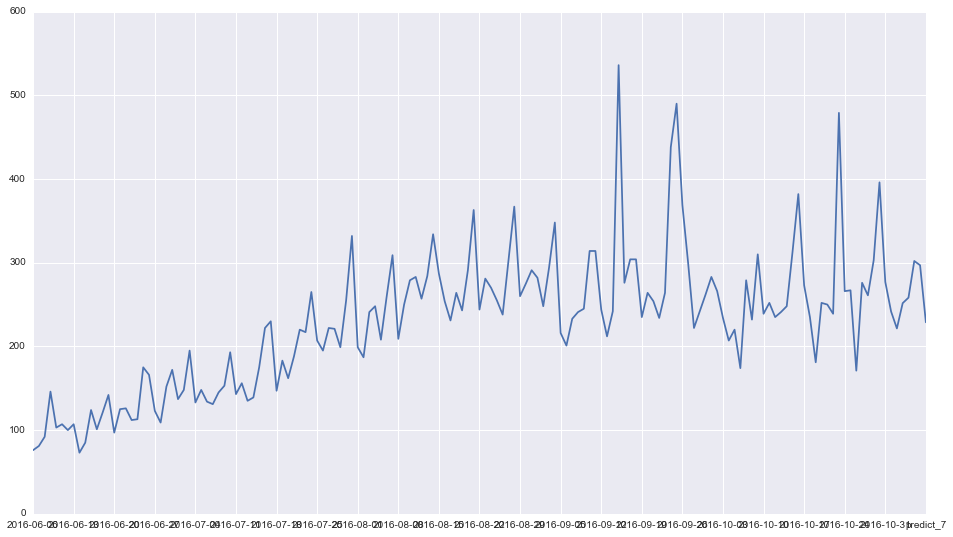

In [114]:

list_result = dateRange('2016-06-06','2016-10-31')
for i in range(1,8):
    list_result.append('predict_'+str(i))

xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
ax = plt.subplot(111) 
ax.xaxis.set_major_locator(xmajorLocator)
shop_info.loc[180,list_result].T.plot(figsize=(16,9),ax=ax)

In [61]:

#  占个格子 &&  cal avg sales count each day
total_day = pd.to_datetime('2016-11-01').date()-pd.to_datetime('2015-07-01').date() 
total_day = total_day.days
total_week = total_day / 7  # 69个
start_day = pd.to_datetime('2016-11-01').date() - datetime.timedelta(total_week*7)
#print start_day
for week_number in range(total_week): # 0~68
    start_day_of_week = start_day +  datetime.timedelta(week_number*7) 
    end_day_of_week = start_day_of_week + datetime.timedelta(6)
    start_day_of_week =   start_day_of_week.strftime("%Y-%m-%d")
    end_day_of_week = end_day_of_week.strftime("%Y-%m-%d")
    print start_day_of_week,end_day_of_week
    shop_info['wk_'+str(week_number)] = shop_info.loc[:,start_day_of_week:end_day_of_week].mean(axis=1)

2015-07-07 2015-07-13
2015-07-14 2015-07-20
2015-07-21 2015-07-27
2015-07-28 2015-08-03
2015-08-04 2015-08-10
2015-08-11 2015-08-17
2015-08-18 2015-08-24
2015-08-25 2015-08-31
2015-09-01 2015-09-07
2015-09-08 2015-09-14
2015-09-15 2015-09-21
2015-09-22 2015-09-28
2015-09-29 2015-10-05
2015-10-06 2015-10-12
2015-10-13 2015-10-19
2015-10-20 2015-10-26
2015-10-27 2015-11-02
2015-11-03 2015-11-09
2015-11-10 2015-11-16
2015-11-17 2015-11-23
2015-11-24 2015-11-30
2015-12-01 2015-12-07
2015-12-08 2015-12-14
2015-12-15 2015-12-21
2015-12-22 2015-12-28
2015-12-29 2016-01-04
2016-01-05 2016-01-11
2016-01-12 2016-01-18
2016-01-19 2016-01-25
2016-01-26 2016-02-01
2016-02-02 2016-02-08
2016-02-09 2016-02-15
2016-02-16 2016-02-22
2016-02-23 2016-02-29
2016-03-01 2016-03-07
2016-03-08 2016-03-14
2016-03-15 2016-03-21
2016-03-22 2016-03-28
2016-03-29 2016-04-04
2016-04-05 2016-04-11
2016-04-12 2016-04-18
2016-04-19 2016-04-25
2016-04-26 2016-05-02
2016-05-03 2016-05-09
2016-05-10 2016-05-16
2016-05-17

In [62]:
shop_info['result_avg'] = shop_info.loc[: ,['predict_'+str(i) for i in range(1,8)]].mean(axis=1)

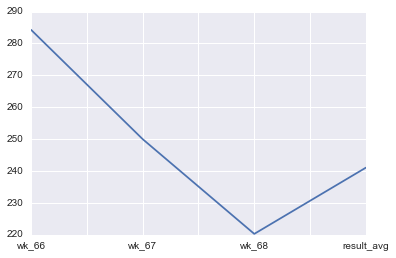

In [76]:
shop_info.loc[39,'wk_66':'result_avg'].plot()

In [ ]:
## 保存结果

In [101]:
result_total = result.join(result2)

In [105]:
for i in range(1,15):
    result_total.loc[:,'predict_'+str(i)] = result_total.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))
    

In [108]:
result_total.to_csv('regression_prediction_two_week.csv', sep=",", index = True)